In [ ]:
#add a code that will clean heart rate data before the feature extraction phase.
#https://www.kaggle.com/code/nelsonsharma/ecg-02-ecg-signal-pre-processing
#https://www.kaggle.com/code/bjoernjostein/heart-rate-variability-hrv-analysis
#https://www.kubios.com/blog/preprocessing-of-hrv-data/

#Installs - for first time only and imports

In [ ]:
!pip install --upgrade wfdb  # Uncomment if running for the first time
!pip install pyhrv==0.4.1  # Install pyHRV v0.4.1
!pip install biosppy==0.7.0 # Install a compatible version of biosppy
!pip install neurokit2

##Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from wfdb import processing
import pandas as pd
import neurokit2 as nk
import pyhrv
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd
import pyhrv.nonlinear as nl
from pyhrv.nonlinear import poincare
from pyhrv.frequency_domain import welch_psd
from pyhrv.nonlinear import sample_entropy
from google.colab import files
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports model

In [ ]:
model = keras.models.load_model("/content/stress_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#Pre-processing

##Feature extraction

In [ ]:
def extract_hrv_features(ecg_signal, sampling_rate=250, datasetId=None):
    # 1. R-peak detection using NeuroKit2
    _, rpeaks_info = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)
    rpeaks = rpeaks_info["ECG_R_Peaks"]  # indices of R-peaks in the signal

    # 2. Compute RR intervals (ms) from consecutive R-peak indices
    rr_intervals = np.diff(rpeaks) / sampling_rate * 1000.0  # convert index difference to milliseconds

    # 3. Remove RR outliers (<300 ms or >2000 ms) to clean artifacts
    rr_intervals = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 2000)]

    # If not enough intervals remain, you may handle separately (not covered here for brevity)

    # 4. Time-domain features
    # Basic statistics on RR intervals
    mean_rr   = float(np.mean(rr_intervals))
    median_rr = float(np.median(rr_intervals))
    sdrr      = float(np.std(rr_intervals, ddof=0))            # SDNN: std of RR
    # Successive differences of RR intervals
    diff_rr   = np.diff(rr_intervals)
    if diff_rr.size > 0:
        rmssd = float(np.sqrt(np.mean(diff_rr**2)))            # RMSSD
        sdsd  = float(np.std(diff_rr, ddof=0))                 # SDSD
    else:
        rmssd = 0.0
        sdsd  = 0.0
    sdrr_rmssd = float(sdrr / rmssd) if rmssd != 0 else 0.0    # ratio SDNN/RMSSD
    # Heart rate (beats per minute) from mean RR (ms)
    hr = float(0.0 if mean_rr == 0 else (60000.0 / mean_rr))
    # pNN25 and pNN50 (percentage of absolute differences above 25 ms and 50 ms)
    abs_diff_rr = np.abs(diff_rr)
    pnn25 = float(100.0 * np.sum(abs_diff_rr > 25) / abs_diff_rr.size) if abs_diff_rr.size > 0 else 0.0
    pnn50 = float(100.0 * np.sum(abs_diff_rr > 50) / abs_diff_rr.size) if abs_diff_rr.size > 0 else 0.0

    # 5. Poincaré plot features (SD1, SD2) and distribution shape (kurtosis, skewness)
    sd1 = float(sdsd / np.sqrt(2.0))
    sd2 = float(np.sqrt(2.0 * (sdrr**2) - 0.5 * (sdsd**2))) if sdrr >= 0 and sdsd >= 0 else 0.0
    # Kurtosis and skewness of RR intervals
    if rr_intervals.size > 0:
        # Using scipy.stats if available; otherwise, compute manually
        # Here we compute population statistics (Fisher's definition for kurtosis)
        m_rr = mean_rr
        std_rr = np.std(rr_intervals, ddof=0)
        if std_rr == 0:
            kurt = 0.0
            skew = 0.0
        else:
            z_rr = (rr_intervals - m_rr) / std_rr
            kurt = float(np.mean(z_rr**4) - 3)  # excess kurtosis
            skew = float(np.mean(z_rr**3))
    else:
        kurt = 0.0
        skew = 0.0

    # 6. Relative RR interval features (ratio of successive RR intervals)
    if rr_intervals.size > 1:
        rel_rr = rr_intervals[1:] / rr_intervals[:-1]  # ratio of each interval to the previous
    else:
        rel_rr = np.array([])
    if rel_rr.size > 0:
        mean_rel_rr   = float(np.mean(rel_rr))
        median_rel_rr = float(np.median(rel_rr))
        sdrr_rel_rr   = float(np.std(rel_rr, ddof=0))
    else:
        mean_rel_rr = 0.0
        median_rel_rr = 0.0
        sdrr_rel_rr = 0.0
    # Differences of relative RR series
    diff_rel_rr = np.diff(rel_rr)
    if diff_rel_rr.size > 0:
        rmssd_rel_rr = float(np.sqrt(np.mean(diff_rel_rr**2)))
        sdsd_rel_rr  = float(np.std(diff_rel_rr, ddof=0))
    else:
        rmssd_rel_rr = 0.0
        sdsd_rel_rr  = 0.0
    sdrr_rmssd_rel_rr = float(sdrr_rel_rr / rmssd_rel_rr) if rmssd_rel_rr != 0 else 0.0
    # Kurtosis and skewness of relative RR series
    if rel_rr.size > 0:
        m_rel = mean_rel_rr
        std_rel = np.std(rel_rr, ddof=0)
        if std_rel == 0:
            kurt_rel_rr = 0.0
            skew_rel_rr = 0.0
        else:
            z_rel = (rel_rr - m_rel) / std_rel
            kurt_rel_rr = float(np.mean(z_rel**4) - 3)
            skew_rel_rr = float(np.mean(z_rel**3))
    else:
        kurt_rel_rr = 0.0
        skew_rel_rr = 0.0

    # 7. Frequency-domain features using Welch's PSD (pyHRV)
    # Compute PSD and frequency-domain metrics
    # Adding 'bc_type='natural'' to welch_psd call
    if len(rr_intervals) < 4: # Corrected indentation here
        # Not enough RR intervals for Welch's PSD analysis
        vlf = lf = hf = vlf_pct = lf_pct = hf_pct = lf_nu = hf_nu = tp = lf_hf = hf_lf = 0.0
    else: # Corrected indentation here
        fd_res = welch_psd(nni=rr_intervals, show=False, show_param=False)
        plt.close('all')
        vlf, lf, hf = fd_res['fft_abs']
        vlf_pct, lf_pct, hf_pct = fd_res['fft_rel']
        lf_nu, hf_nu = fd_res['fft_norm']
        tp = fd_res['fft_total']
        lf_hf = fd_res['fft_ratio']
        hf_lf = float(hf / lf) if lf != 0 else float('inf')

        # Absolute powers [ms^2] in VLF, LF, HF bands
        vlf, lf, hf = fd_res['fft_abs']
        # Relative powers [% of total power]
        vlf_pct, lf_pct, hf_pct = fd_res['fft_rel']
        # Normalized units (LF, HF)
        lf_nu, hf_nu = fd_res['fft_norm']
        # Total power and LF/HF ratio
        tp = fd_res['fft_total']
        lf_hf = fd_res['fft_ratio']
        hf_lf = float(hf / lf) if lf != 0 else float('inf')

    # 8. Non-linear features: Sample Entropy and Higuchi Fractal Dimension
    sampen_res = sample_entropy(nni=rr_intervals)
    sampen_val = sampen_res['sampen']
    # Higuchi fractal dimension using NeuroKit2
    if len(rr_intervals) >= 3:
        hfd_val, _ = nk.fractal_higuchi(rr_intervals, show=False)
    else:
        hfd_val = 0.0
    # 9. Compile all features into a list in the specified order
    features = [
        mean_rr, median_rr, sdrr, rmssd, sdsd, sdrr_rmssd, hr, pnn25, pnn50,
        sd1, sd2, kurt, skew,
        mean_rel_rr, median_rel_rr, sdrr_rel_rr, rmssd_rel_rr, sdsd_rel_rr, sdrr_rmssd_rel_rr, kurt_rel_rr, skew_rel_rr,
        float(vlf), float(vlf_pct), float(lf), float(lf_pct), float(lf_nu), float(hf), float(hf_pct), float(hf_nu),
        float(tp), float(lf_hf), float(hf_lf),
        float(sampen_val), float(hfd_val),
        datasetId
    ]
    return features

##Main

In [ ]:
def extract_date_from_dataframe(df):
    """Extracts the date (YYYYMMDD) from the first row of the Time column."""
    time_str = df.iloc[0, 1]  # Assuming 'Time' is the second column (index 1)
    dt = pd.to_datetime(time_str)
    return dt.strftime('%Y%m%d')
#df = pd.read_csv('/content/p4_day20160504_part0.csv', header=None, skiprows=1)
#date_str = extract_date_from_dataframe(df)
#print(date_str)  # ➝ '20160504'

In [ ]:
def predict(input_path,output_path):
  fs = 250
  df = pd.read_csv(input_path, header=None, skiprows=1)
  ecg = df[2].values.astype(float)  # Changed np.float to float
  Time_str = extract_date_from_dataframe(df)
  features = extract_hrv_features(ecg_signal=ecg, sampling_rate=fs, datasetId=f"{Time_str}")
  feature_names = [ # Corrected indentation here
    "MEAN_RR", "MEDIAN_RR", "SDRR", "RMSSD", "SDSD", "SDRR_RMSSD", "HR",
    "pNN25", "pNN50", "SD1", "SD2", "KURT", "SKEW",
    "MEAN_REL_RR", "MEDIAN_REL_RR", "SDRR_REL_RR", "RMSSD_REL_RR", "SDSD_REL_RR",
    "SDRR_RMSSD_REL_RR", "KURT_REL_RR", "SKEW_REL_RR",
    "VLF", "VLF_PCT", "LF", "LF_PCT", "LF_NU",
    "HF", "HF_PCT", "HF_NU", "TP", "LF_HF", "HF_LF",
    "sampen", "higuci", "datasetId"]
  print("📊 HRV Feature Vector:")
  for name, value in zip(feature_names, features):
    print(f"{name:25}: {value}")
  df_features = pd.DataFrame([features], columns=feature_names)
  # Save to CSV
  df_features.to_csv(output_path, index=False)
  print(f"✅ HRV features saved to {output_path}")
  # Exclude the last element (datasetId) if it's a string
  X = np.array(features[:-1], dtype=np.float32)
  # Reshape to match model input: (batch_size, 1, num_features)
  X = X.reshape(1, 1, -1)
  # Predict stress level
  prediction = model.predict(X)
  # Get class label
  predicted_class = np.argmax(prediction)
  # Optional: Map class indices to labels (adjust based on your original model training)
  labels = ["No Stress", "Mild Stress", "High Stress"]
  print("🧠 Predicted Stress Level:", labels[predicted_class])

predict("/content/drive/MyDrive/project/p13_20160415/p13_day20160415_part0.csv","/content/features.csv")

ValueError: cannot embed data of length 1 with embedding dimension 3 and lag 1, minimum required length is 3

##Data processint and plot

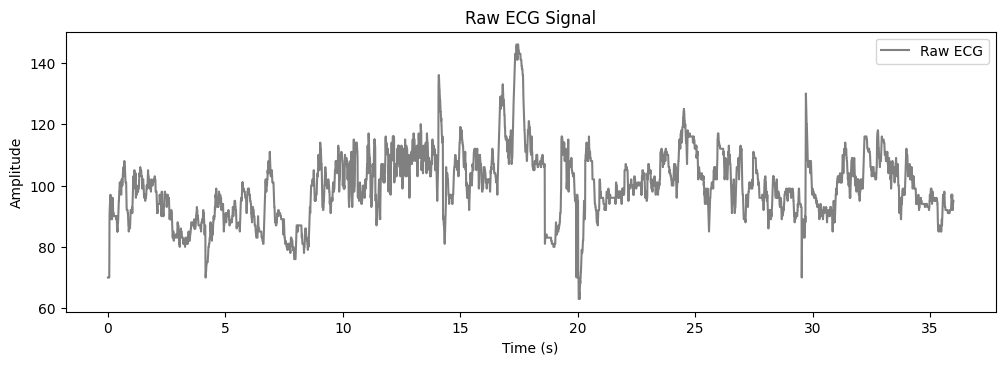

In [ ]:
def plot_raw_and_processed_ecg(raw_signal, processed_signal, r_peaks, fs):
    times = np.arange(len(raw_signal)) / fs
    plt.figure(figsize=(12, 8))
    # Plot 1: Raw ECG
    plt.subplot(2, 1, 1)
    plt.plot(times, raw_signal, label="Raw ECG", color='gray')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Raw ECG Signal")
    plt.legend()
    plt.show()
plot_raw_and_processed_ecg(ecg, normalized, r_peaks, fs)

##Data Analysis

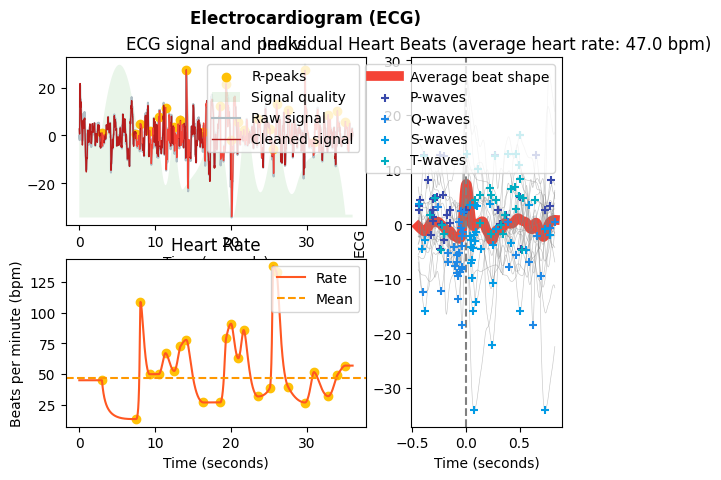

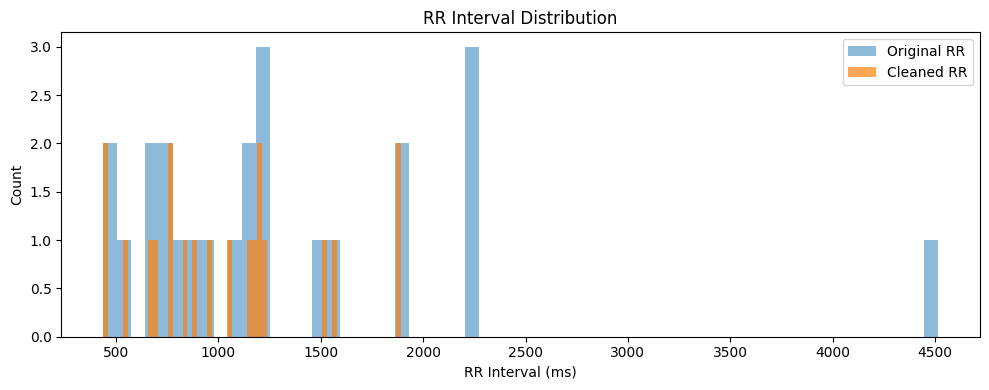

🔹 NeuroKit2 HRV Time-Domain:
    HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1336.333333  878.257497         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5    HRV_RMSSD     HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  1092.617758  1106.534468  ...      868.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0      0.80381        736.0       1884.8  83.333333  83.333333      436.0   

   HRV_MaxNN  HRV_HTI   HRV_TINN  
0     4516.0      8.0  1804.6875  

[1 rows x 25 columns]
   HRV_ULF  HRV_VLF  HRV_LF    HRV_HF   HRV_VHF    HRV_TP  HRV_LFHF  HRV_LFn  \
0      NaN      NaN     NaN  0.052578  0.000784  0.053362       NaN      NaN   

    HRV_HFn  HRV_LnHF  
0  0.985307 -2.945454  

🔹 pyHRV Time-Domain (Using NeuroKit2 results):
    HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1336.333333  878.257497         NaN         NaN         NaN         NaN   

   HRV_SD

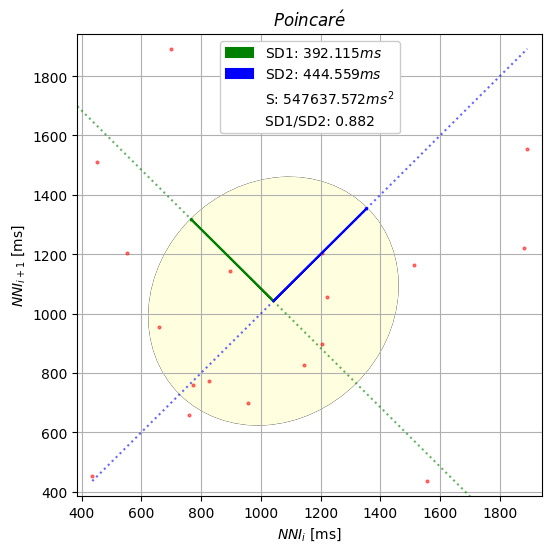

ReturnTuple(poincare_plot=<Figure size 600x600 with 1 Axes>, sd1=np.float64(392.11513940228883), sd2=np.float64(444.5593541818478), sd_ratio=np.float64(1.133746977633919), ellipse_area=np.float64(547637.571762242))

In [ ]:
# === 1. Load ECG Data ===
fs = 250  # Sampling rate (Hz)
df = pd.read_csv('/content/p4_day20160504_part1.csv', header=None, skiprows=1)
ecg = df[2].values.astype(np.float64)

# === 2. Clean ECG Signal ===
ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=fs)

# === 3. Detect R-peaks and Process Signal ===
ecg_signals, info = nk.ecg_process(ecg_cleaned, sampling_rate=fs)
rpeaks = info["ECG_R_Peaks"]
rr_intervals = np.diff(rpeaks) / fs * 1000  # RR intervals in ms

# === 4. Remove Extreme RR Values ===
rr_clean = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 2000)]

# === 5. Visualize ECG with R-peaks ===
nk.ecg_plot(ecg_signals, info)

# === 6. Visualize RR Distribution ===
plt.figure(figsize=(10, 4))
plt.hist(rr_intervals, bins=60, alpha=0.5, label='Original RR')
plt.hist(rr_clean, bins=60, alpha=0.7, label='Cleaned RR')
plt.xlabel("RR Interval (ms)")
plt.ylabel("Count")
plt.title("RR Interval Distribution")
plt.legend()
plt.tight_layout()
plt.show()

# === 7. HRV Analysis with NeuroKit2 ===
print("🔹 NeuroKit2 HRV Time-Domain:")
hrv_time_results = nk.hrv_time(ecg_signals, sampling_rate=fs)  # Store results
print(hrv_time_results)
print(nk.hrv_frequency(ecg_signals, sampling_rate=fs))

# === 8. HRV Analysis with pyHRV ===
# Convert clean RR intervals to pyHRV-compatible format
rr_list = rr_clean.tolist()

# print("\n🔹 pyHRV Time-Domain:")  # Comment out the pyHRV Time-Domain calculations
# td_results = td.time_domain(rr_list)  # Comment out pyHRV calculation
# print(td_results)  # Comment out to avoid error

# Instead, print NeuroKit2 Time-Domain HRV
print("\n🔹 pyHRV Time-Domain (Using NeuroKit2 results):")
print(hrv_time_results)  # Use results from NeuroKit2


# === 9. Optional: Plot Poincaré ===
print("\n📈 Poincaré plot (pyHRV)")
# Call the 'poincare' function directly
poincare(rr_list, show=True) # poincare function is now imported correctly

##Feature extraction

In [ ]:
test_df = pd.read_csv("/content/test.csv")
df_features.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId
0,935.483871,876.0,437.58014,522.297999,521.539755,0.837798,64.137931,96.666667,93.333333,368.784297,...,28.703666,90982.107961,58.629174,71.296334,155182.312673,0.402597,2.483876,1.098612,1.7952,day20160504


In [ ]:
test_df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,721.901897,727.267280,74.722315,12.361264,12.361069,6.044877,84.121868,4.933333,0.000000,8.743513,...,66.617057,3.921868,9.760289,1698.605390,9.245599,0.108160,2.097342,1.243696,2,no stress
1,843.538633,844.407930,58.499429,19.298880,19.298795,3.031234,71.478642,21.000000,0.200000,13.650863,...,26.500086,1.123416,1.663151,2358.884694,59.126832,0.016913,2.217275,1.250056,2,time pressure
2,958.523868,966.671125,132.849110,21.342715,21.342653,6.224565,63.874293,24.133333,1.800000,15.096571,...,16.024935,0.370208,0.766416,4328.633724,129.477524,0.007723,2.217136,1.144943,2,no stress
3,824.838669,842.485905,117.822094,11.771814,11.771248,10.008830,74.330531,4.733333,0.533333,8.326307,...,17.581470,0.615932,3.358652,2854.449091,28.773854,0.034754,2.106863,1.142355,2,no stress
4,756.707933,747.941620,143.968457,13.357748,13.356388,10.777899,82.092049,5.933333,0.666667,9.447545,...,35.199054,0.662879,6.292253,5310.027472,14.892559,0.067148,1.912191,1.128098,2,interruption
